# ArbeitSooNahe Consulting: SHAP (SHapley Additive exPlanations) and GPT for explainable AI on a recommendation model.

This notebook provides an example implementation of explainable AI using SHAP (SHapley Additive exPlanations) after training a machine learning model (GBDT, GBM) on XGBoost (an optimized distributed gradient boosting library).

The SHAP code is used to explain the decisions of the model trained to recommend matching installation consultants with customers.

**Relevant features:** `consultant skills, location, availability, historical feedback, and project requirements`.





### 1. Install dependencies

In [ ]:
!pip install xgboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.2 MB/s eta 0:00:00


### 2. Train Model

Ensure that you have a dataset with the mentioned features and a target variable that indicates a successful match.

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np

# Example dataset
data = {
    'Consultant_skills': np.random.rand(100),
    'Location': np.random.choice(['Location1', 'Location2', 'Location3'], 100),
    'Availability': np.random.randint(0, 2, 100),
    'Historical_feedback': np.random.rand(100),
    'Project_requirements': np.random.rand(100),
    'Target': np.random.randint(0, 2, 100)
}

df = pd.DataFrame(data)

# Convert categorical features to numeric
df = pd.get_dummies(df, columns=['Location'])

# Separate features and target
X = df.drop(columns=['Target'])
y = df['Target']

# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 3. Create SHAP Explainer

Use the appropriate SHAP explainer for your model. For tree-based models like **XGBoost** or LightGBM, use TreeExplainer.

In [ ]:
import shap

explainer = shap.TreeExplainer(model)

### 4. Compute SHAP Values

Calculate SHAP values for the dataset.

In [ ]:
shap_values = explainer.shap_values(X)

### 5. Visualize SHAP Values

*   Summary Plot: Shows the impact of all features.
*   Dependence Plot: Shows the effect of a single feature across the dataset.
*   Force Plot: Visualizes the SHAP values for a single prediction. Here, we will look at the first instance.



### Summary Plot

This plot shows the impact, distribution, and importance of features. The features are sorted by importance, and the color represents the feature value (red high, blue low).

**Key Components:**

- Feature Importance: Features are sorted by their importance, which is the mean absolute value of the SHAP values for each feature across all samples.
- SHAP Value: The horizontal axis represents the SHAP value, indicating the impact of the feature on the prediction. Higher absolute SHAP values signify a greater impact.
- Color: Each point is colored based on the feature value (red indicates high values, blue indicates low values).

**What it Tells You:**

- Importance Ranking: The plot shows which features are most influential in making predictions.
- Feature Effect: It reveals how the values of the features impact the model's output. For instance, if higher values of a feature (red points) are associated with positive SHAP values, it means that higher values of this feature increase the model's prediction.

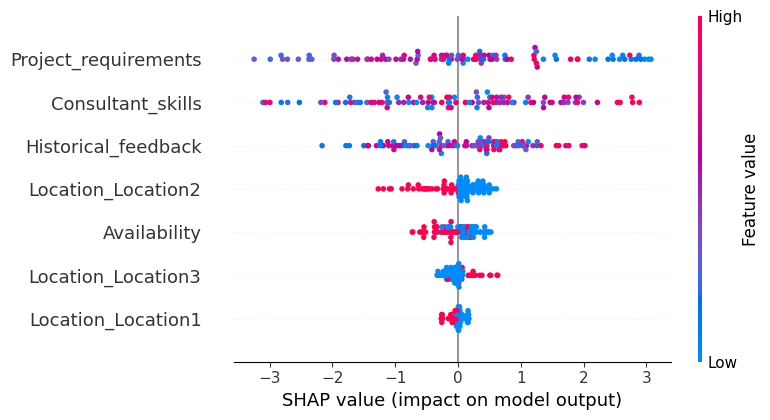

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X)

### Dependence Plot

This plot shows the relationship between the feature value and the SHAP value for a specific feature. It helps to understand how the feature contributes to the prediction across different values.

**Key Components:**

- Feature Value: The horizontal axis represents the values of the selected feature.
- SHAP Value: The vertical axis shows the SHAP values for the feature, representing its impact on the prediction.
- Color: The points are colored based on the value of another feature (interaction effect), helping to understand interactions between features.

**What it Tells You:**

- Feature Impact: It shows whether an increase in the feature value leads to an increase or decrease in the prediction.
- Interactions: The color coding can reveal interactions between features. For example, the impact of one feature may depend on the value of another feature.

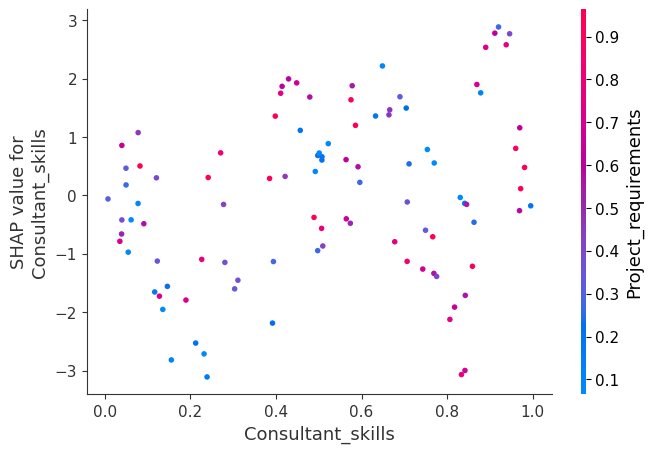

In [ ]:
shap.initjs()
shap.dependence_plot("Consultant_skills", shap_values, X)

### Force Plot

This plot provides a visual explanation for a single prediction, showing how each feature contributes to pushing the prediction from the base value to the final output.

**Key Components:**

- Base Value: The starting point of the plot (typically the average prediction value across the dataset).
- SHAP Values: Arrows pushing the prediction higher or lower based on each feature's impact.
- Prediction: The final predicted value after accounting for all feature contributions.

**What it Tells You:**

- Individual Contribution: It shows how each feature's value influences the prediction for a specific instance.
- Positive/Negative Impact: Features pushing the prediction to be higher (positive SHAP values) are shown in one direction (usually right), while those pushing it lower (negative SHAP values) are shown in the opposite direction (usually left).

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

### 6. Generating explanations in natural language (OpenAI's GPT)

In [ ]:
### Version 1: Using example values for SHAP ###

# Example values
base_value = 0.45
prediction = 0.75

explanations = [
    "The feature 'Consultant_skills' with a value of 0.85 contributed to an increase in the predicted probability by 0.10.",
    "The feature 'Location_Location1' with a value of 1 contributed to an increase in the predicted probability by 0.05.",
    "The feature 'Availability' with a value of 1 contributed to an increase in the predicted probability by 0.07.",
    "The feature 'Historical_feedback' with a value of 0.92 contributed to an increase in the predicted probability by 0.08.",
    "The feature 'Project_requirements' with a value of 0.40 contributed to a decrease in the predicted probability by 0.05."
]

# Create the prompt
prompt = (
    f"The model made a prediction with the following details:\n\n"
    f"Base value: {base_value}\n"
    f"Prediction: {prediction}\n\n"
    f"Explanations:\n" + "\n".join(f"{i+1}. {explanation}" for i, explanation in enumerate(explanations))
)

# Get the response from GPT
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    max_tokens=150
)

# Print the response (for GPT)
print(response.choices[0].text.strip())


# Alternatively, a model from the ChatGPT series such as GPT-4 and adjust the OpenAI API's call
response = openai.ChatCompletion.create(
    model="gpt-4",  # Use the ChatGPT model
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ],
    max_tokens=150
)

# Print the response (for ChatGPT: GPT-4)
print(response.choices[0].message['content'].strip())


##################################################


### Version 2: Reading values for a specific instance's prediction directly from SHAP explanations ###

# Compute SHAP values
shap_values = explainer.shap_values(X)
# Select an instance to explain
instance_idx = 0
instance = X.iloc[instance_idx]
shap_values_instance = shap_values[instance_idx]

# Function to generate natural language explanation
def generate_natural_language_explanation(instance, shap_values_instance, feature_names):
    base_value = explainer.expected_value
    prediction = model.predict_proba(instance.values.reshape(1, -1))[0][1]

    explanations = []
    for feature_value, shap_value, feature_name in zip(instance, shap_values_instance, feature_names):
        impact = "increase" if shap_value > 0 else "decrease"
        explanations.append(f"The feature '{feature_name}' with a value of {feature_value} contributed to a {impact} in the predicted probability by {abs(shap_value):.3f}.")

    return explanations, base_value, prediction

# Generate explanations
explanations, base_value, prediction = generate_natural_language_explanation(instance, shap_values_instance, X.columns)

# Create the prompt
prompt = (
    f"The model made a prediction with the following details:\n\n"
    f"Base value: {base_value:.3f}\n"
    f"Prediction: {prediction:.3f}\n\n"
    f"Explanations:\n" + "\n".join(f"{i+1}. {explanation}" for i, explanation in enumerate(explanations))
)

# Get the response from GPT
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    max_tokens=150
)

# Print the response
print(response.choices[0].text.strip())

### Example

**Input for GPT model:** The input to GPT can be formatted as a prompt with the base value, prediction, and explanations. For example:

"

The model made a prediction with the following details:

Base value: 0.45
Prediction: 0.75

Explanations:
1. The feature 'Consultant_skills' with a value of 0.85 contributed to an increase in the predicted probability by 0.10.
2. The feature 'Location_Location1' with a value of 1 contributed to an increase in the predicted probability by 0.05.
3. The feature 'Availability' with a value of 1 contributed to an increase in the predicted probability by 0.07.
4. The feature 'Historical_feedback' with a value of 0.92 contributed to an increase in the predicted probability by 0.08.
5. The feature 'Project_requirements' with a value of 0.40 contributed to a decrease in the predicted probability by 0.05.

"

**Output from GPT:** Based on the input prompt, GPT might generate the following output:

"

The model predicted a high likelihood (0.75) of matching this consultant with a customer. Here’s why:

1. The consultant has high skill levels (0.85), which significantly increased the prediction by 0.10. High skill levels are crucial for successful project matches.
2. The consultant is located in Location1, which also contributed positively to the prediction by 0.05. This indicates that Location1 is a preferred or highly demanded area.
3. The consultant is currently available (availability score of 1), adding another 0.07 to the prediction. Availability is a key factor in matching.
4. The consultant has excellent historical feedback (0.92), further increasing the prediction by 0.08. Positive feedback from previous projects strongly influences the matching likelihood.
5. The project requirements (0.40) slightly decreased the prediction by 0.05. This suggests that the project requirements may not be an ideal fit for the consultant, but this factor is outweighed by the other positive contributions.

Overall, the consultant's skills, location, availability, and historical feedback are the main reasons for the high prediction, despite some slight misalignment with the project requirements.

"